In [4]:
import os
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn.functional as F


In [51]:
# Clean the data by removing bluryy images

def is_blurry(image_path, threshold=100):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.Laplacian(gray, cv2.CV_64F).var()
    return blur < threshold

def remove_blurry_images(folder_path, threshold=150):
    blurry_images = []
    count = 0
    for folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, folder)
        if not os.path.isdir(class_path):
            continue
        for filename in os.listdir(class_path):
            if not filename.endswith(('.png', '.jpg', '.jpeg')):
                continue
            count += 1
            image_path = os.path.join(class_path, filename)
            if is_blurry(image_path, threshold):
                blurry_images.append(filename)
                os.remove(image_path)
    print(count)
    print(len(blurry_images))

folder_path = 'data2'
blurry_images_removed = remove_blurry_images(folder_path, threshold=150)

5873
0


In [28]:
import mtcnn
face_detector = mtcnn.MTCNN()

In [4]:
# Clean the data if face is not present in image
def is_face_present(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    detected_faces = face_detector.detect_faces(image)

    for face in detected_faces:
        if face['confidence'] >= 0.9:
            return True
    return False

def remove_images_without_face(folder_path):
    no_face_images = []
    count = 0
    for folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, folder)
        if not os.path.isdir(class_path):
            continue
        for filename in os.listdir(class_path):
            if not filename.endswith(('.png', '.jpg', '.jpeg')):
                continue
            count += 1
            image_path = os.path.join(class_path, filename)
            if not is_face_present(image_path):
                no_face_images.append(filename)
                os.remove(image_path)
    print(count)
    print(len(no_face_images))

folder_path = 'data2'
blurry_images_removed = remove_images_without_face(folder_path)

3281
553


In [11]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.Grayscale(),    
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

full_dataset = datasets.ImageFolder(root='data2')

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size 

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

batch_size = 64 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 32 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

# with batch normalization
class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.bn1(self.pool(F.relu(self.conv1(x))))
        x = self.dropout1(x)
        x = self.bn2(self.pool(F.relu(self.conv2(x))))
        x = self.dropout2(x)
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x


model = CNNModel()

model2 = CNNModel()


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [13]:
def plot_confusion_matrix(cm):
    class_labels = full_dataset.classes

    plt.figure(figsize=(8, 6))
    sns.set_theme(font_scale=1.2)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [14]:

def train(model, train_loader, optimizer, criterion, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0.0
        correct = 0
        total = 0
        for index, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = training_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        val_results = validate(model, val_loader, criterion)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_losses.append(val_results[5])
        val_accuracies.append(val_results[0])
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Training Acc: {epoch_acc:.4f}, Val Acc: {val_results[0]:.4f}')
    torch.save(model.state_dict(), 'cnn_model.pth')

    return (train_losses, val_losses, train_accuracies, val_accuracies)


def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            y_true.extend(val_labels.cpu().numpy())
            y_pred.extend(val_predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    val_loss = val_loss/len(val_loader.dataset)

    return [accuracy, precision, recall, f1, cm, val_loss]

Epoch 1/10, Loss: 1.7142, Training Acc: 0.3722, Val Acc: 0.5056
Epoch 2/10, Loss: 0.9740, Training Acc: 0.5350, Val Acc: 0.5953
Epoch 3/10, Loss: 0.8914, Training Acc: 0.5878, Val Acc: 0.6164
Epoch 4/10, Loss: 0.8726, Training Acc: 0.6011, Val Acc: 0.6090
Epoch 5/10, Loss: 0.8544, Training Acc: 0.6051, Val Acc: 0.6364
Epoch 6/10, Loss: 0.8317, Training Acc: 0.6257, Val Acc: 0.5766
Epoch 7/10, Loss: 0.8450, Training Acc: 0.6099, Val Acc: 0.6700
Epoch 8/10, Loss: 0.8271, Training Acc: 0.6294, Val Acc: 0.6401
Epoch 9/10, Loss: 0.8394, Training Acc: 0.6233, Val Acc: 0.6115
Epoch 10/10, Loss: 0.8084, Training Acc: 0.6377, Val Acc: 0.6239


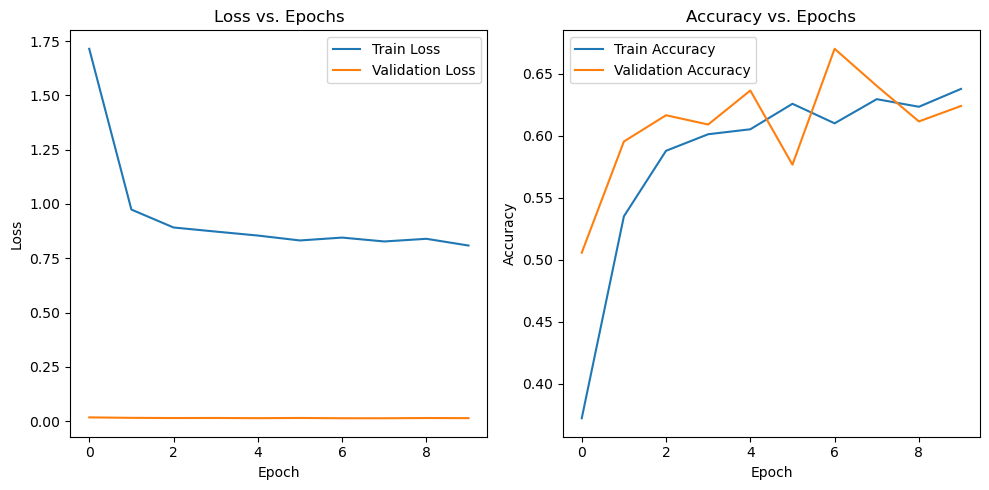

In [15]:
num_epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, optimizer, criterion, num_epochs=num_epochs)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10, Loss: 1.4600, Training Acc: 0.4208, Val Acc: 0.5417
Epoch 2/10, Loss: 0.8813, Training Acc: 0.6006, Val Acc: 0.6164
Epoch 3/10, Loss: 0.8311, Training Acc: 0.6265, Val Acc: 0.6463
Epoch 4/10, Loss: 0.7923, Training Acc: 0.6494, Val Acc: 0.6538
Epoch 5/10, Loss: 0.7616, Training Acc: 0.6628, Val Acc: 0.6787
Epoch 6/10, Loss: 0.7936, Training Acc: 0.6406, Val Acc: 0.6613
Epoch 7/10, Loss: 0.7411, Training Acc: 0.6790, Val Acc: 0.6401
Epoch 8/10, Loss: 0.7058, Training Acc: 0.6886, Val Acc: 0.6563
Epoch 9/10, Loss: 0.6833, Training Acc: 0.7092, Val Acc: 0.6775
Epoch 10/10, Loss: 0.6552, Training Acc: 0.7215, Val Acc: 0.6899


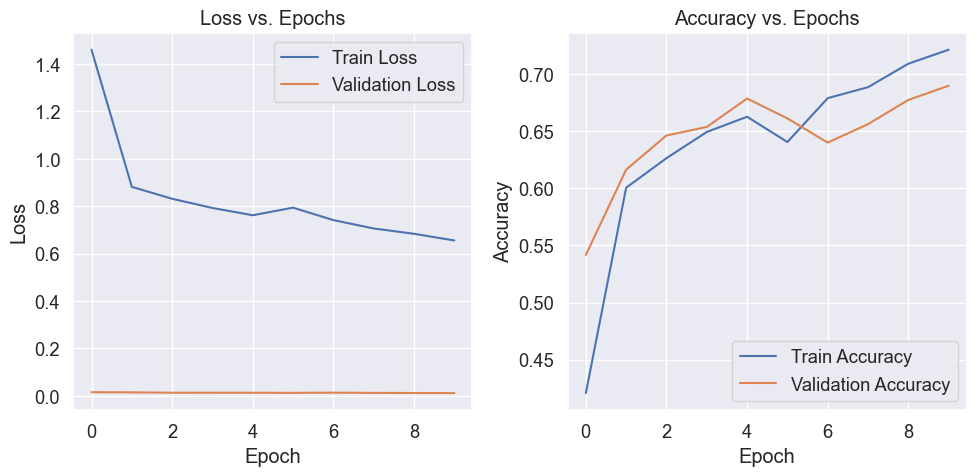

In [93]:


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model1 = CNNModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001, weight_decay=0.01)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = train(model1, train_loader, optimizer, criterion, num_epochs=num_epochs)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test Dataset size:  804
Testing set Accuracy:  0.6865671641791045


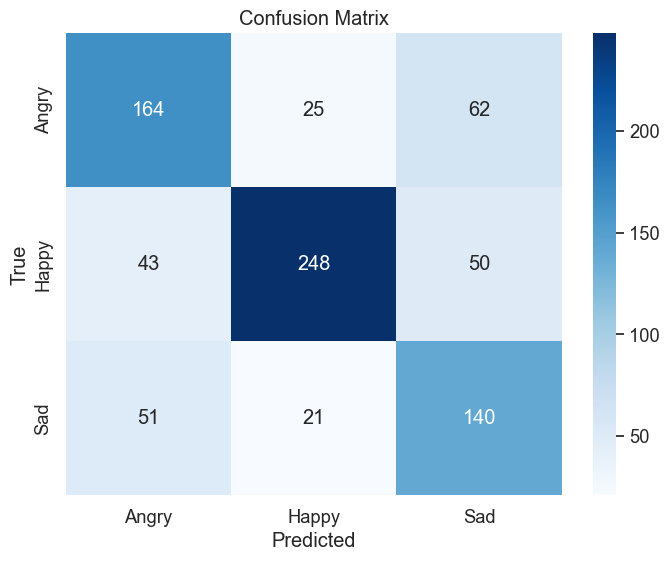

In [18]:
results = validate(model, test_loader, criterion)
print('Test Dataset size: ', len(test_dataset))
print('Testing set Accuracy: ', results[0])

plot_confusion_matrix(results[4])

In [ ]:
results = validate(model1, test_loader, criterion)
print('Testing set Accuracy: ', results[0])
plot_confusion_matrix(results[4])

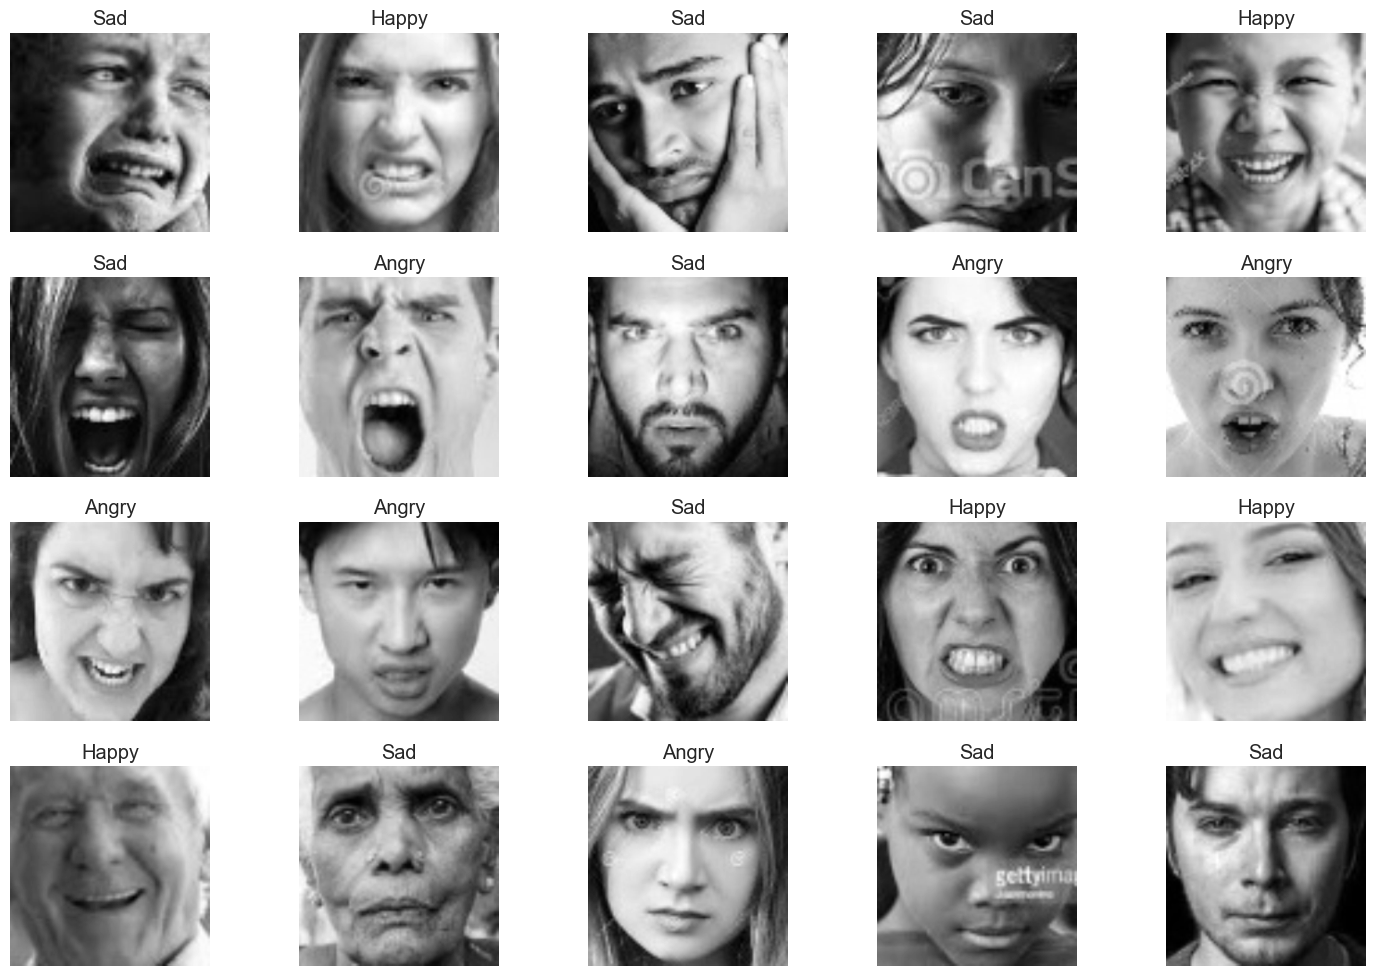

15


In [68]:
# Test for a random 20 samples and plot from the test dataset

import random
class_names = full_dataset.classes

random_indices = random.sample(range(len(test_dataset)), 20)

sample_images = []
predicted_emotions = []
count = 0

for idx in random_indices:
    image, label = test_dataset[idx]
    predicted_label = model(image.unsqueeze(0)).argmax().item()
    predicted_emotion = class_names[predicted_label]
    if predicted_label == label:
        count += 1
    sample_images.append(image)
    predicted_emotions.append(predicted_emotion)

plt.figure(figsize=(15, 10))
for i in range(len(sample_images)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title(predicted_emotions[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
print(count)


In [39]:
# Live video recognition
cap = cv2.VideoCapture(0)
class_names = full_dataset.classes

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cv2.waitKey(1000)

while cap.isOpened():
    ret, frame = cap.read() 
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    # faces = face_detector.detect_faces(frame)

    for (x,y,w,h) in faces:
    # for face in faces:
    #     (x, y, w, h) = face['box']
        # if face['confidence'] < 0.9:
        #     continue
        face_roi = frame[y:y+h, x:x+w]

        face_img = val_test_transforms(face_roi)
        input_tensor = face_img.unsqueeze(0)

        with torch.no_grad():
            output = model(input_tensor)

        predicted_index = torch.argmax(output, dim=1).item()
        predicted_class = class_names[predicted_index]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, f'Emotion: {predicted_class}', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2.imshow('Live Emotion Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

cv2.destroyAllWindows()

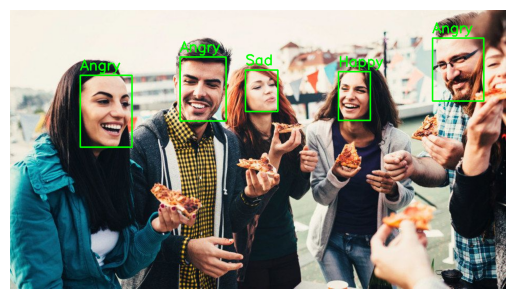

In [73]:
# Test on old datset image
model.eval()
import cv2
from PIL import Image

image_path = '/Users/davinci/Desktop/dhanush/projects/emotion_recognition/data/Happy/56f455011e0000b300705475.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

faces = face_detector.detect_faces(image)

for face in faces:
    (x, y, w, h) = face['box']
    if face['confidence'] < 0.9:
        continue
    face_roi = image[y:y+h, x:x+w]
    face_roi = Image.fromarray(face_roi)

    input_image = val_test_transforms(face_roi)
    input_image = input_image.unsqueeze(0)

    with torch.no_grad():
        output = model(input_image)
    predicted_label = output.argmax().item()
    predicted_emotion = class_names[predicted_label]

    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(image, f'{predicted_emotion}', (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

plt.imshow(image)
plt.axis('off')
plt.show()


[{'box': [17, 415, 675, 984], 'confidence': 0.9998410940170288, 'keypoints': {'left_eye': (145, 789), 'right_eye': (455, 775), 'nose': (265, 924), 'mouth_left': (190, 1155), 'mouth_right': (437, 1152)}}, {'box': [2433, 267, 776, 1201], 'confidence': 0.9995495676994324, 'keypoints': {'left_eye': (2629, 704), 'right_eye': (2986, 690), 'nose': (2805, 917), 'mouth_left': (2673, 1170), 'mouth_right': (2944, 1162)}}, {'box': [1452, 443, 681, 1029], 'confidence': 0.998247504234314, 'keypoints': {'left_eye': (1643, 800), 'right_eye': (1955, 809), 'nose': (1804, 982), 'mouth_left': (1665, 1183), 'mouth_right': (1922, 1185)}}, {'box': [409, 261, 738, 1175], 'confidence': 0.9953966736793518, 'keypoints': {'left_eye': (617, 730), 'right_eye': (987, 740), 'nose': (801, 959), 'mouth_left': (649, 1135), 'mouth_right': (939, 1140)}}, {'box': [1014, 430, 653, 999], 'confidence': 0.9909325838088989, 'keypoints': {'left_eye': (1167, 871), 'right_eye': (1500, 834), 'nose': (1343, 1070), 'mouth_left': (123

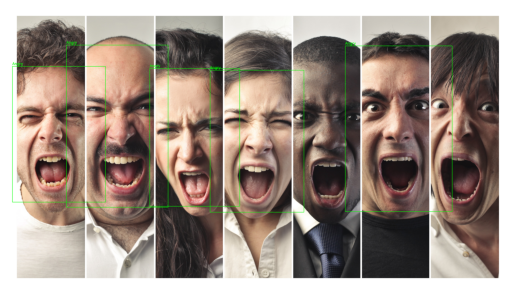

In [80]:
# image_path = '/Users/davinci/Desktop/dhanush/projects/emotion_recognition/data/Happy/56f455011e0000b300705475.jpeg'
image_path = '/Users/davinci/Desktop/dhanush/projects/emotion_recognition/data/Angry/Angry-people-2.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

faces = face_detector.detect_faces(image)
print(faces)
for face in faces:
    (x, y, w, h) = face['box']
    if face['confidence'] < 0.9:
        continue
    face_roi = image[y:y+h, x:x+w]
    face_roi = Image.fromarray(face_roi)

    input_image = val_test_transforms(face_roi)
    input_image = input_image.unsqueeze(0)

    with torch.no_grad():
        output = model(input_image)
    predicted_label = output.argmax().item()
    predicted_emotion = class_names[predicted_label]

    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(image, f'{predicted_emotion}', (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

plt.imshow(image)
plt.axis('off')
plt.show()


In [27]:
import torch
import torch.nn as nn


checkpoint = torch.load('cnn_model.pth')
model = CNNModel()
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [33]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

def get_grad_cam(model, image, target_layer):
    
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    input_tensor = preprocess(image).unsqueeze(0)
    input_tensor.requires_grad = True

    model.eval()
    activations = {}
    def save_activation(name):
        def hook(model, input, output):
            activations[name] = output
        return hook

    hook_handle = target_layer.register_forward_hook(save_activation('target'))

    output = model(input_tensor)

    hook_handle.remove()

    target_activations = activations['target']
    if not target_activations.requires_grad:
        raise RuntimeError("No gradients computed for target activations")

    gradients = torch.autograd.grad(outputs=target_activations.sum(), inputs=input_tensor,
                                    create_graph=True)[0]

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    target_activations = target_activations[0] 
    for i in range(gradients.shape[1]):
        target_activations[i, :, :] *= pooled_gradients[i]

    grad_cam = torch.nn.functional.relu(target_activations.sum(dim=0)).detach()
    grad_cam = torch.nn.functional.interpolate(grad_cam.unsqueeze(0).unsqueeze(0), 
                                               size=(224, 224), mode='bilinear', align_corners=False)
    grad_cam = grad_cam.squeeze().numpy()

    return grad_cam


[6, 0, 67, 76]


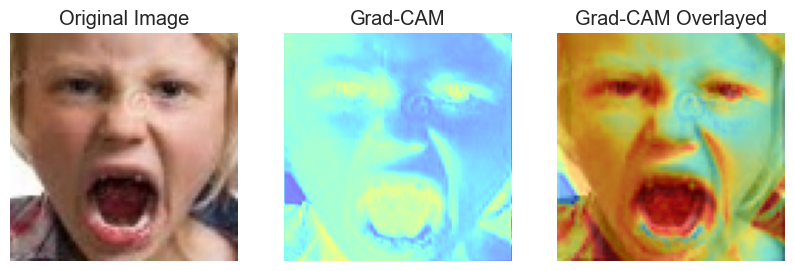

In [55]:
# Trying to visualize feature heatmaps (WIP)
target_layer = model.conv1

image_path = 'data2/Angry/anger3 copy.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
faces = face_detector.detect_faces(image)

for face in faces:
    (x, y, w, h) = face['box']
    print(face['box'])
    if face['confidence'] < 0.9:
        continue
    face_roi = image[y:y+h, x:x+w]
    face_roi = Image.fromarray(face_roi)
    grad_cam = get_grad_cam(model, face_roi, target_layer)
    break

original_image = Image.open(image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grad_cam, cmap='jet', alpha=0.5)
plt.title('Grad-CAM')
plt.axis('off')

grad_cam_colored = plt.get_cmap('jet')(grad_cam)[:, :, :3]
grad_cam_colored = (grad_cam_colored * 255).astype(np.uint8)
grad_cam_image = Image.fromarray(grad_cam_colored)

grad_cam_image = grad_cam_image.resize(original_image.size, Image.LANCZOS)

original_image_rgba = original_image.convert('RGBA')
grad_cam_image_rgba = grad_cam_image.convert('RGBA')

blended_image = Image.blend(original_image_rgba, grad_cam_image_rgba, alpha=0.5)

plt.subplot(1, 3, 3)
plt.imshow(blended_image)
plt.title('Grad-CAM Overlayed')
plt.axis('off')

plt.show()

[4, 0, 68, 76]


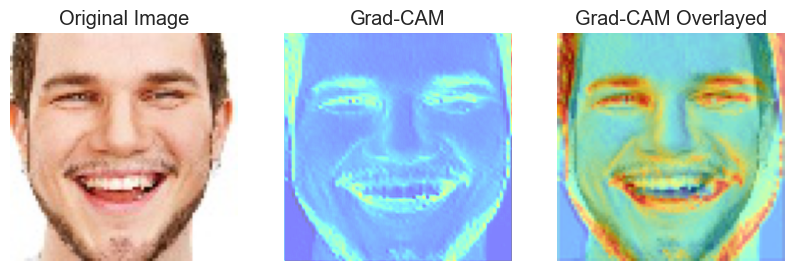

In [54]:
image_path = "data2/Happy/happiness34 copy.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
faces = face_detector.detect_faces(image)

for face in faces:
    (x, y, w, h) = face['box']
    print(face['box'])
    if face['confidence'] < 0.9:
        continue
    face_roi = image[y:y+h, x:x+w]
    face_roi = Image.fromarray(face_roi)
    grad_cam = get_grad_cam(model, face_roi, target_layer)
    break

original_image = Image.open(image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grad_cam, cmap='jet', alpha=0.5)
plt.title('Grad-CAM')
plt.axis('off')

grad_cam_colored = plt.get_cmap('jet')(grad_cam)[:, :, :3]
grad_cam_colored = (grad_cam_colored * 255).astype(np.uint8)
grad_cam_image = Image.fromarray(grad_cam_colored)

grad_cam_image = grad_cam_image.resize(original_image.size, Image.LANCZOS)

original_image_rgba = original_image.convert('RGBA')
grad_cam_image_rgba = grad_cam_image.convert('RGBA')

blended_image = Image.blend(original_image_rgba, grad_cam_image_rgba, alpha=0.5)

plt.subplot(1, 3, 3)
plt.imshow(blended_image)
plt.title('Grad-CAM Overlayed')
plt.axis('off')

plt.show()

Total convolution layers: 2
1/1 [==============================] - 0s 53ms/step

Feature maps shape
torch.Size([1, 16, 224, 224])
torch.Size([1, 32, 224, 224])

 Processed feature maps shape
(224, 224)
(224, 224)


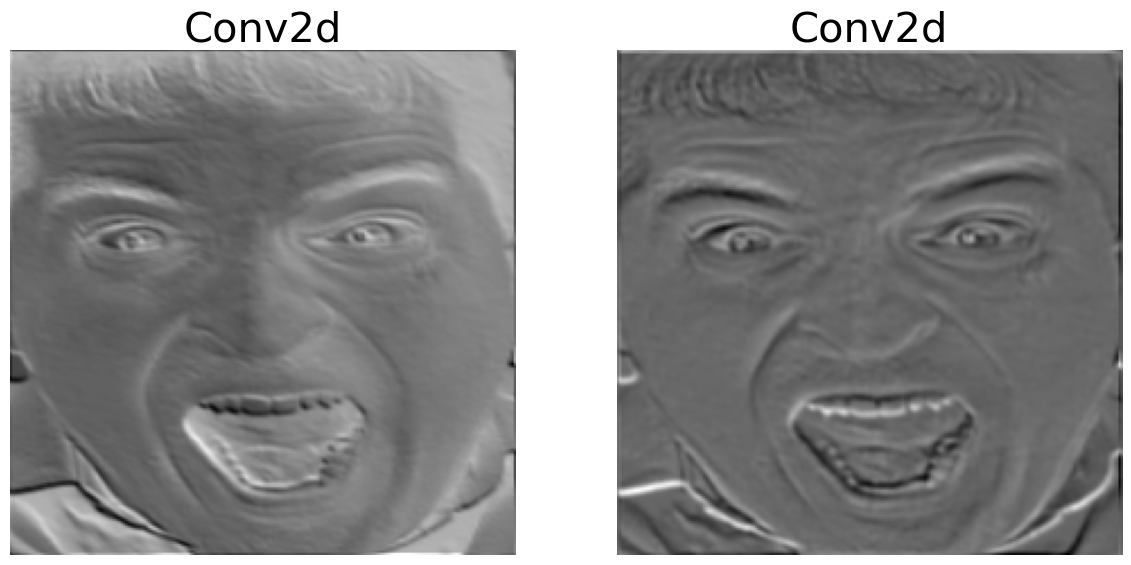

In [49]:
conv_weights = []
conv_layers = []
total_conv_layers = 0

for module in model.children():
	if isinstance(module, nn.Conv2d):
		total_conv_layers += 1
		conv_weights.append(module.weight)
		conv_layers.append(module)

print(f"Total convolution layers: {total_conv_layers}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image = cv2.imread(image_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

faces = face_detector.detect_faces(image)

for face in faces:
    (x, y, w, h) = face['box']
    if face['confidence'] < 0.9:
        continue
    face_roi = image[y:y+h, x:x+w]

    input_image = val_test_transforms(face_roi)
    input_image = input_image.unsqueeze(0)

feature_maps = [] 
layer_names = []
for layer in conv_layers:
	input_image = layer(input_image)
	feature_maps.append(input_image)
	layer_names.append(str(layer))

print("\nFeature maps shape")
for feature_map in feature_maps:
	print(feature_map.shape)

processed_feature_maps = []
for feature_map in feature_maps:
	feature_map = feature_map.squeeze(0)
	mean_feature_map = torch.sum(feature_map, 0) / feature_map.shape[0]
	processed_feature_maps.append(mean_feature_map.data.cpu().numpy())
print("\n Processed feature maps shape")
for fm in processed_feature_maps:
	print(fm.shape)

fig = plt.figure(figsize=(30, 50))
for i in range(len(processed_feature_maps)):
	ax = fig.add_subplot(5, 4, i + 1)
	ax.imshow(processed_feature_maps[i], cmap='gray')
	ax.axis("off")
	ax.set_title(layer_names[i].split('(')[0], fontsize=30)
